# 5B_mg_fig3_motif_scan

05/27/2020


In [51]:
import pandas as pd
import os,glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
import time
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
save_dir = '../data/processed/fig3_footprinting'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [8]:
annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
annon_df['id_new'] = annon_df['id'] + '.pwm.trim'
annon_df[['motif_abbr','motif_info']]=annon_df['id'].str.split("_",expand=True)
annon_dict = pd.Series(annon_df.tf.values, index=annon_df.motif_abbr.values).to_dict()
anno

# cluster the hocomoco stuff

In [93]:
clusters_df = pd.read_csv('/Users/mguo123/Documents/rsat/hocomoco_human_cluster/clusters_tf.csv')
clusters_df.columns = ['id','cluster']
clusters_df[['motif_abbr','motif_info']]=clusters_df['id'].str.split("_",expand=True)
clusters_df['tf'] = clusters_df['motif_abbr'].map(annon_dict)
clusters_df.sort_values('cluster',inplace=True)
clusters_df_tf = clusters_df.groupby('tf').first() 
clusters_df_tf.sort_values('cluster',inplace=True)
len(set(clusters_df_tf['cluster'])) # number of clusters

130

In [97]:
clusters_df_tf

,id,cluster,motif_abbr,motif_info
tf,,,,
AHR,AHR_HUMAN.H11MO.0.B,1,AHR,HUMAN.H11MO.0.B
HIF1A,HIF1A_HUMAN.H11MO.0.C,1,HIF1A,HUMAN.H11MO.0.C
ARNT2,ARNT2_HUMAN.H11MO.0.D,1,ARNT2,HUMAN.H11MO.0.D
ARNT,ARNT_HUMAN.H11MO.0.B,1,ARNT,HUMAN.H11MO.0.B
EPAS1,EPAS1_HUMAN.H11MO.0.B,1,EPAS1,HUMAN.H11MO.0.B
...,...,...,...,...
ZIC3,ZIC3_HUMAN.H11MO.0.B,129,ZIC3,HUMAN.H11MO.0.B
ZNF257,ZN257_HUMAN.H11MO.0.C,130,ZN257,HUMAN.H11MO.0.C
ZNF410,ZN410_HUMAN.H11MO.0.D,131,ZN410,HUMAN.H11MO.0.D


In [2]:
glob.glob('../data/raw/motif_scan/*bed')

['../data/raw/motif_scan/Esophageal_mpbs.bed',
 '../data/raw/motif_scan/Prostate_mpbs.bed',
 '../data/raw/motif_scan/GDS-D3_mpbs.bed',
 '../data/raw/motif_scan/Bladder_mpbs.bed',
 '../data/raw/motif_scan/Airway_mpbs.bed',
 '../data/raw/motif_scan/GM12878_mpbs.bed',
 '../data/raw/motif_scan/GDS-D0_mpbs.bed',
 '../data/raw/motif_scan/Astrocytes_mpbs.bed',
 '../data/raw/motif_scan/HMEC_mpbs.bed',
 '../data/raw/motif_scan/Melanocytes_mpbs.bed',
 '../data/raw/motif_scan/Pancreas_mpbs.bed',
 '../data/raw/motif_scan/Colon_mpbs.bed',
 '../data/raw/motif_scan/GDS-D6_mpbs.bed',
 '../data/raw/motif_scan/Ovarian_mpbs.bed']

In [43]:
tissue_map = {
    'Airway':'Airway',
    'Astrocytes':'Astrocytes',
    'Bladder':'Bladder',
    'Colon':'Colon',
    'Esophageal':'Esophageal',
    'GDSD0':'GDS-D0',
    'GDSD3':'GDS-D3',
    'GDSD6':'GDS-D6',
    'GM12878':'GM12878',
    'HMEC':'HMEC',
    'Melanocytes':'Melanocytes',
    'Ovarian':'Ovarian',
    'Pancreas':'Pancreas',
    'Prostate':'Prostate',
    'Renal':'Renal',
    'Thyroid':'Thyroid',
    'Uterine':'Uterine'   
}

In [42]:
%%time
scores_all = pd.DataFrame()
for tissue in ['Astrocytes','GDSD0','GDSD3','GDSD6','GM12878','Melanocytes']:
    print(tissue)
    start = time.time()
    bed_file = '../data/raw/motif_scan/' + tissue_map[tissue] + '_mpbs.bed'
    bed_df = pd.read_csv(bed_file, sep='\t',header=None)
    bed_df.columns = ['chr', 'start', 'end', 'id', 'score', 'strand', 'etc']
    bed_df[['motif_name', 'info']] = bed_df['id'].str.split('_',expand=True)
    bed_df['tf'] = bed_df.motif_name.map(annon_dict)
    scores = bed_df.groupby('tf').agg(
    {'score':'mean','id':'count'}
    ).sort_values('score')
    scores.reset_index(inplace=True)
    scores.columns = ['tf','score', 'count']
    scores['tissue'] = tissue
    
    scores_all = pd.concat([scores_all,scores],sort=False)
    
    print(tissue,time.time()-start)


Astrocytes
GDSD0
GDSD3
GDSD6
GM12878
Melanocytes
CPU times: user 24min 11s, sys: 1min 2s, total: 25min 14s
Wall time: 24min 36s


In [46]:
scores_all_sel = scores_all.copy()

In [82]:
scores_all_sel_piv = scores_all_sel.pivot('tissue','tf','count')
scores_all_sel_piv_norm = scores_all_sel_piv / scores_all_sel_piv.sum(axis=0)
scores_all_sel_piv_norm = scores_all_sel_piv_norm.divide(np.array(scores_all_sel_piv.sum(axis=1)),axis='rows')
scores_all_sel_piv_norm = scores_all_sel_piv_norm* scores_all_sel_piv.sum().sum()
scores_all_sel_piv_norm = scores_all_sel_piv_norm.applymap(lambda x: max(1e-3,x))

In [86]:
scores_all_sel_piv_norm.to_csv(os.path.join(save_dir, 'scores_all_sel_piv_norm.csv'))
os.path.join(save_dir, 'scores_all_sel_piv_norm.csv')

'../data/processed/fig3_footprinting/scores_all_sel_piv_norm.csv'

In [65]:
scores_all_sel_piv / scores_all_sel_piv.sum(axis=0)

tf,AHR,AIRE,ALX1,ALX3,ALX4,AR,ARID3A,ARID5B,ARNT,ARNT2,...,ZNF76,ZNF768,ZNF770,ZNF784,ZNF8-ERVK3-1,ZNF816,ZNF85,ZSCAN16,ZSCAN22,ZSCAN31
tissue,,,,,,,,,,,,,,,,,,,,,
Astrocytes,0.131342,0.098605,0.076319,0.077749,0.078593,0.085137,0.070681,0.080721,0.134200,0.145211,...,0.135860,0.114198,0.141040,0.118301,0.074654,0.134977,0.085449,0.090827,0.144258,0.132232
GDSD0,0.175406,0.199042,0.210722,0.207687,0.209101,0.198472,0.204117,0.206531,0.173527,0.165459,...,0.175915,0.183920,0.165969,0.187652,0.211680,0.171517,0.207134,0.199398,0.163748,0.176175
GDSD3,0.191888,0.214359,0.232368,0.232521,0.233987,0.216582,0.225959,0.224375,0.193102,0.182798,...,0.193657,0.202409,0.185626,0.204100,0.231034,0.191601,0.227040,0.214077,0.183369,0.192884
GDSD6,0.173562,0.195917,0.218954,0.221414,0.221748,0.199498,0.194931,0.204459,0.175919,0.164563,...,0.173304,0.187021,0.165947,0.186149,0.215340,0.170563,0.210253,0.199301,0.163533,0.174923
GM12878,0.185472,0.181495,0.169823,0.171304,0.168697,0.195927,0.202863,0.184422,0.177782,0.183726,...,0.174223,0.187210,0.182031,0.193444,0.176711,0.184018,0.169124,0.191637,0.182964,0.177046
Melanocytes,0.142330,0.110582,0.091814,0.089326,0.087874,0.104385,0.101448,0.099491,0.145470,0.158243,...,0.147041,0.125242,0.159387,0.110353,0.090581,0.147323,0.101000,0.104761,0.162130,0.146740


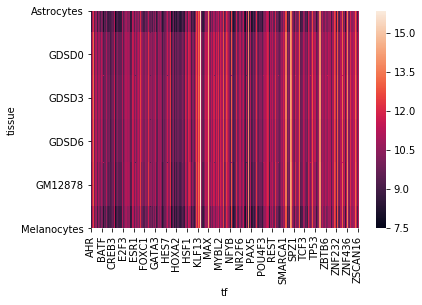

In [52]:
sns.heatmap(np.log(scores_all_sel.pivot('tissue','tf','count')))

In [5]:
%%time
tissue = 'GDSD0'
bed_file = '../data/raw/motif_scan/GDS-D0_mpbs.bed'

bed_df = pd.read_csv(bed_file, sep='\t',header=None)
bed_df.columns = ['chr', 'start', 'end', 'id', 'score', 'strand', 'etc']
bed_df[['motif_name', 'info']] = bed_df['id'].str.split('_',expand=True)
bed_df['tf'] = bed_df.motif_name.map(annon_dict)

In [33]:
scores = bed_df.groupby('tf').agg(
    {'score':'mean','id':'count'}
).sort_values('score')
scores.reset_index(inplace=True)
scores.columns = ['tf','score', 'count']
scores['tissue'] = tissue


# Footprint - select

In [99]:
glob.glob( '../data/interim/merged/footprinting/*')

['../data/interim/merged/footprinting/COLO_SCR_PLX_merged.bed',
 '../data/interim/merged/footprinting/D6-p63i_merged.bed',
 '../data/interim/merged/footprinting/COLO_shMITF_PLX_merged.bed',
 '../data/interim/merged/footprinting/D3-CTRLi_merged.bed',
 '../data/interim/merged/footprinting/Icon\r',
 '../data/interim/merged/footprinting/Renal_merged.bed',
 '../data/interim/merged/footprinting/Prostate_merged.bed',
 '../data/interim/merged/footprinting/A431-p63i_merged.bed',
 '../data/interim/merged/footprinting/COLO_shMITF_DMSO_merged.bed',
 '../data/interim/merged/footprinting/Uterine_merged.bed',
 '../data/interim/merged/footprinting/GDSD6_merged.bed',
 '../data/interim/merged/footprinting/Pancreas_merged.bed',
 '../data/interim/merged/footprinting/WM_SCR_DMSO_merged.bed',
 '../data/interim/merged/footprinting/SCC13-CTRLi_merged.bed',
 '../data/interim/merged/footprinting/D6-CTRLi_merged.bed',
 '../data/interim/merged/footprinting/Melanocytes_merged.bed',
 '../data/interim/merged/footpri

In [114]:
%%time
scores_all_foot = pd.DataFrame()
for tissue in ['Astrocytes','GDSD0','GDSD3','GDSD6','GM12878','Melanocytes']:
    print(tissue)
    start = time.time()
    bed_file = '../data/interim/merged/footprinting/' + tissue + '_merged.bed'
    bed_df = pd.read_csv(bed_file, sep='\t',header=None)
    bed_df.columns = ['chr', 'start', 'end', 'id', 'score', 'strand', 'etc']
    bed_df[['motif_name', 'info']] = bed_df['id'].str.split('_',expand=True)
    bed_df['tf'] = bed_df.motif_name.map(annon_dict)
    scores = bed_df.groupby('tf').agg(
    {'score':'mean','id':'count'}
    ).sort_values('score')
    scores.reset_index(inplace=True)
    scores.columns = ['tf','score', 'count']
    scores['tissue'] = tissue
    
    scores_all_foot = pd.concat([scores_all_foot,scores],sort=False)
    
    print(tissue,time.time()-start)


Astrocytes
Astrocytes 3.956490993499756
GDSD0
GDSD0 9.95537281036377
GDSD3
GDSD3 10.968613147735596
GDSD6
GDSD6 11.776802062988281
GM12878
GM12878 9.248206853866577
Melanocytes
Melanocytes 4.8802170753479
CPU times: user 1min 8s, sys: 1.28 s, total: 1min 9s
Wall time: 50.8 s


In [116]:
scores_all_foot.groupby(['tf','tissue']).count().sort_values('count')

score  count
tf      tissue                   
AHR     Astrocytes       1      1
RARA    GM12878          1      1
        Melanocytes      1      1
RARB    Astrocytes       1      1
        GDSD0            1      1
...                    ...    ...
HOXB7   Melanocytes      1      1
HOXB8   Astrocytes       1      1
        GDSD0            1      1
HOXB6   Astrocytes       1      1
ZSCAN31 Melanocytes      1      1

[4068 rows x 2 columns]

In [117]:
scores_all_foot_piv = scores_all_foot.pivot('tissue','tf','count')
scores_all_foot_piv_norm = scores_all_foot_piv / scores_all_foot_piv.sum(axis=0)
scores_all_foot_piv_norm = scores_all_foot_piv_norm.divide(np.array(scores_all_foot_piv.sum(axis=1)),axis='rows')
scores_all_foot_piv_norm = scores_all_foot_piv_norm* scores_all_foot_piv.sum().sum()
scores_all_foot_piv_norm = scores_all_foot_piv_norm.applymap(lambda x: max(1e-3,x))

In [118]:
scores_all_foot_piv_norm.to_csv(os.path.join(save_dir, 'scores_all_sel_foot_norm.csv'))
os.path.join(save_dir, 'scores_all_sel_foot_norm.csv')

'../data/processed/fig3_footprinting/scores_all_sel_foot_norm.csv'

# Footprint - all

dict_keys(['Airway', 'Astrocytes', 'Bladder', 'Colon', 'Esophageal', 'GDSD0', 'GDSD3', 'GDSD6', 'GM12878', 'HMEC', 'Melanocytes', 'Ovarian', 'Pancreas', 'Prostate', 'Renal', 'Thyroid', 'Uterine'])

In [125]:
%%time
scores_all_foot_all_tissue = pd.DataFrame()
for tissue in tissue_map.keys():
    print(tissue)
    start = time.time()
    bed_file = '../data/interim/merged/footprinting/' + tissue + '_merged.bed'
    bed_df = pd.read_csv(bed_file, sep='\t',header=None)
    bed_df.columns = ['chr', 'start', 'end', 'id', 'score', 'strand', 'etc']
    bed_df[['motif_name', 'info']] = bed_df['id'].str.split('_',expand=True)
    bed_df['tf'] = bed_df.motif_name.map(annon_dict)
    scores = bed_df.groupby('tf').agg(
    {'score':'mean','id':'count'}
    ).sort_values('score')
    scores.reset_index(inplace=True)
    scores.columns = ['tf','score', 'count']
    scores['tissue'] = tissue
    
    scores_all_foot_all_tissue = pd.concat([scores_all_foot_all_tissue,scores],sort=False)
    
    print(tissue,time.time()-start)


Airway
Airway 12.271987915039062
Astrocytes
Astrocytes 3.7625107765197754
Bladder
Bladder 12.995601892471313
Colon
Colon 10.859875917434692
Esophageal
Esophageal 11.661785125732422
GDSD0
GDSD0 10.77812910079956
GDSD3
GDSD3 10.128572940826416
GDSD6
GDSD6 11.559014081954956
GM12878
GM12878 8.696696996688843
HMEC
HMEC 9.779805183410645
Melanocytes
Melanocytes 5.293838977813721
Ovarian
Ovarian 5.054127216339111
Pancreas
Pancreas 11.908933162689209
Prostate
Prostate 5.249614953994751
Renal
Renal 12.046571016311646
Thyroid
Thyroid 10.954993963241577
Uterine
Uterine 14.07914113998413
CPU times: user 3min 42s, sys: 5.95 s, total: 3min 48s
Wall time: 2min 47s


In [127]:
scores_all_foot_all_tissue_piv = scores_all_foot_all_tissue.pivot('tissue','tf','count')
scores_all_foot_all_tissue_piv_norm = scores_all_foot_all_tissue_piv / scores_all_foot_all_tissue_piv.sum(axis=0)
scores_all_foot_all_tissue_piv_norm = scores_all_foot_all_tissue_piv_norm.divide(np.array(scores_all_foot_all_tissue_piv.sum(axis=1)),axis='rows')
scores_all_foot_all_tissue_piv_norm = scores_all_foot_all_tissue_piv_norm* scores_all_foot_all_tissue_piv.sum().sum()
scores_all_foot_all_tissue_piv_norm = scores_all_foot_all_tissue_piv_norm.applymap(lambda x: max(1e-3,x))

In [128]:
scores_all_foot_all_tissue_piv_norm.to_csv(os.path.join(save_dir, 'scores_all_foot_all_tissue_piv_norm.csv'))
os.path.join(save_dir, 'scores_all_foot_all_tissue_piv_norm.csv')

'../data/processed/fig3_footprinting/scores_all_foot_all_tissue_piv_norm.csv'